# IMPORTS

In [1]:
import numpy as np 
import pandas as pd 

from warnings import filterwarnings 

filterwarnings('ignore')

# DATA READ

In [2]:
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')
sample_submission = pd.read_csv('./input/samp_sub.csv')

In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# EDA BLOCK

In [5]:
print(train.apply(lambda col: col.unique()))
print(test.apply(lambda col: col.unique()))

id          [1, 4, 5, 6, 7, 8, 10, 13, 14, 15, 16, 17, 18,...
keyword     [nan, ablaze, accident, aftershock, airplane%2...
location    [nan, Birmingham, Est. September 2012 - Bristo...
text        [Our Deeds are the Reason of this #earthquake ...
target                                                 [1, 0]
dtype: object
id          [0, 2, 3, 9, 11, 12, 21, 22, 27, 29, 30, 35, 4...
keyword     [nan, ablaze, accident, aftershock, airplane%2...
location    [nan, London, Niall's place | SAF 12 SQUAD |, ...
text        [Just happened a terrible car crash, Heard abo...
dtype: object


In [6]:
import matplotlib.pyplot as plt 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import spacy
import en_core_web_sm
import re

In [7]:
from sklearn.model_selection import train_test_split

X = train['text'] + ' ' + train['keyword'].astype(str) + ' ' + train['location'].astype(str)
y = train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [8]:
X_train[:100]

5145    Salem 2 nuclear reactor shut down over electri...
5262    Refugio oil spill may have been costlier bigge...
2874    @KarinaGarciaxo_ me &amp; you both &amp; I'll ...
2491    Unexercised honda run-down neighborhood desola...
1401    Countless Casualties All Across The Globe War ...
                              ...                        
6924    Live updates: Boyd gets out of trouble in 5th ...
908     @MariaSherwood2 @JohnJCampbell Mega bloody mar...
494     Telnet attacked from 124.13.172.40 (STREAMYX-H...
947     My dogÛªs just blown his kennel up ÛÒ Bloody...
3145    STL Ace Grille - Surface Mounts SpeedTech Ligh...
Length: 100, dtype: object

In [16]:
punctuations = string.punctuation
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS
parser = English()

In [17]:
def spacy_tokinizer(sentence):
    mytokens = str(sentence)
    mytokens = nlp(mytokens)
    mytokens = [word.lemma_.lower().strip() if word.lemma_ != '-PRON-' else word.lower_ for word in mytokens]
    mytokens = [word for word in mytokens if word not in stop_words and word not in punctuations]
    return mytokens

In [18]:
class Predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def get_params(self, deep=True):
        return {}
    
def clean_text(text):
    text = text.strip().lower()
    return text

bow_vector = CountVectorizer(tokenizer=spacy_tokinizer, ngram_range=(1,1), stop_words=None)
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokinizer, stop_words=None)

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
classifier = LogisticRegression()

pipe = Pipeline([('cleaner', Predictors()),
                 ('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

In [20]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('cleaner', <__main__.Predictors object at 0x000001DE89762250>),
                ('vectorizer',
                 TfidfVectorizer(tokenizer=<function spacy_tokinizer at 0x000001DE84908DC0>)),
                ('classifier', LogisticRegression())])

In [21]:
from sklearn import metrics

In [22]:
predicted = pipe.predict(X_test)

print('Accuracy: ', metrics.accuracy_score(y_test, predicted))
print('Precision: ', metrics.precision_score(y_test, predicted))
print('Recall: ', metrics.recall_score(y_test, predicted))

Accuracy:  0.792907180385289
Precision:  0.7883040935672515
Recall:  0.6977225672877847


In [23]:
predicted_df = pd.DataFrame(predicted)
predicted_df.value_counts()

0    1429
1     855
dtype: int64

<AxesSubplot:ylabel='Frequency'>

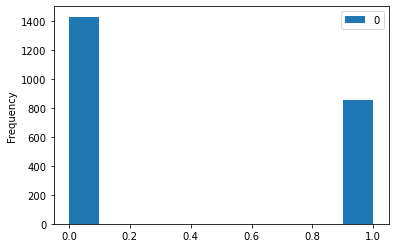

In [24]:
predicted_df.plot.hist()

In [25]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [26]:
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [27]:
my_submission_preds = pipe.predict(test['text'] + ' ' + test['keyword'].astype(str) + ' ' + test['location'].astype(str))
my_submission = pd.DataFrame({"id": test['id'], 'target': my_submission_preds})

In [28]:
my_submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


# SAVE THE RESULTS

In [29]:
my_submission.to_csv('submission.csv', index=False)